In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.result import ProbDistribution
from circuit_knitting.cutting.cutqc import reconstruct_full_distribution, cut_circuit_wires, evaluate_subcircuits
from backend import fake_backend_guadalupe, transpiler_fake_backend_guadalupe, sampler_fake_backend_guadalupe
from utils import save_cuts, save_probs, save_reconstructed_probs

In [2]:
FILE_PREFIX = "16-qubits-GHZ"

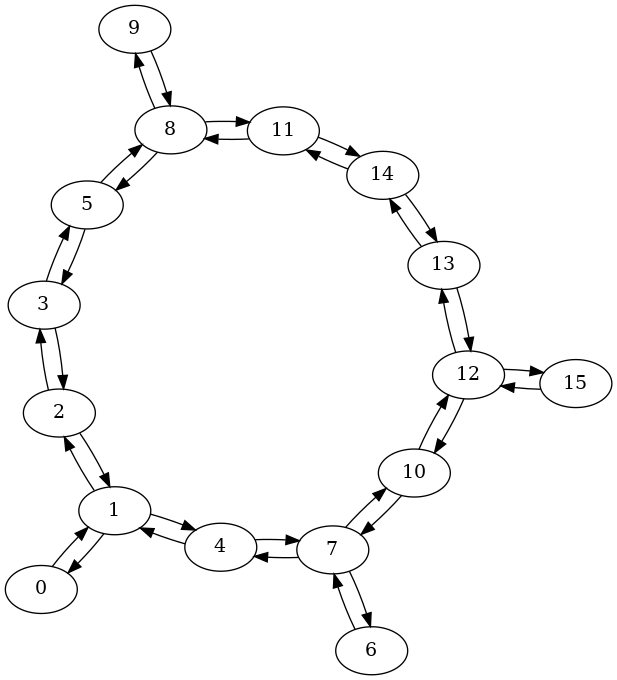

In [3]:
fake_backend_guadalupe.coupling_map.draw()

In [4]:
starting_node = 0
couplings = [
    (0, 1),
    (1, 4),
    (1, 2),
    (2, 3),
    (3, 5),
    (5, 8),
    (8, 9),
    (8, 11),
    (11, 14),
    (14, 13),
    (13, 12),
    (12, 15),
    (12, 10),
    (10, 7),
    (7, 6)
]

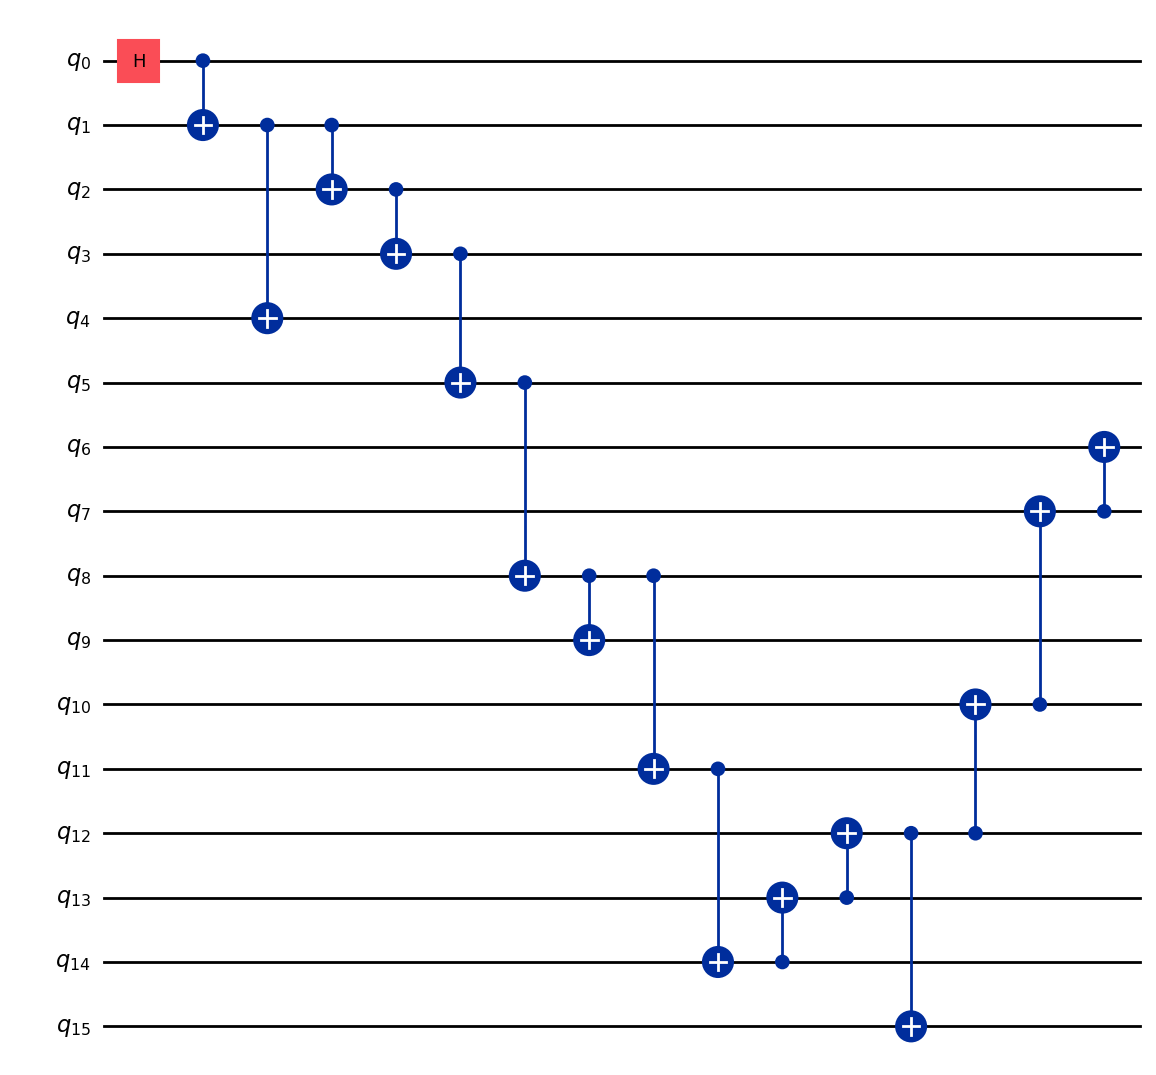

In [5]:
n_qubits = fake_backend_guadalupe.num_qubits
qc = QuantumCircuit(n_qubits)
qc.h(starting_node)
for i,j in couplings:
    qc.cx(i,j)
qc.draw('mpl', filename=f"{FILE_PREFIX}-circuit.png")

In [6]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

In [7]:
qc_c = qc.copy()
qc_c.measure_all()
transpiled_qc = transpiler_fake_backend_guadalupe.run(qc_c)
print(f'qc depth: {qc_c.depth()}')
print(f'transpiled qc depth: {transpiled_qc.depth()}')

qc depth: 17
transpiled qc depth: 19


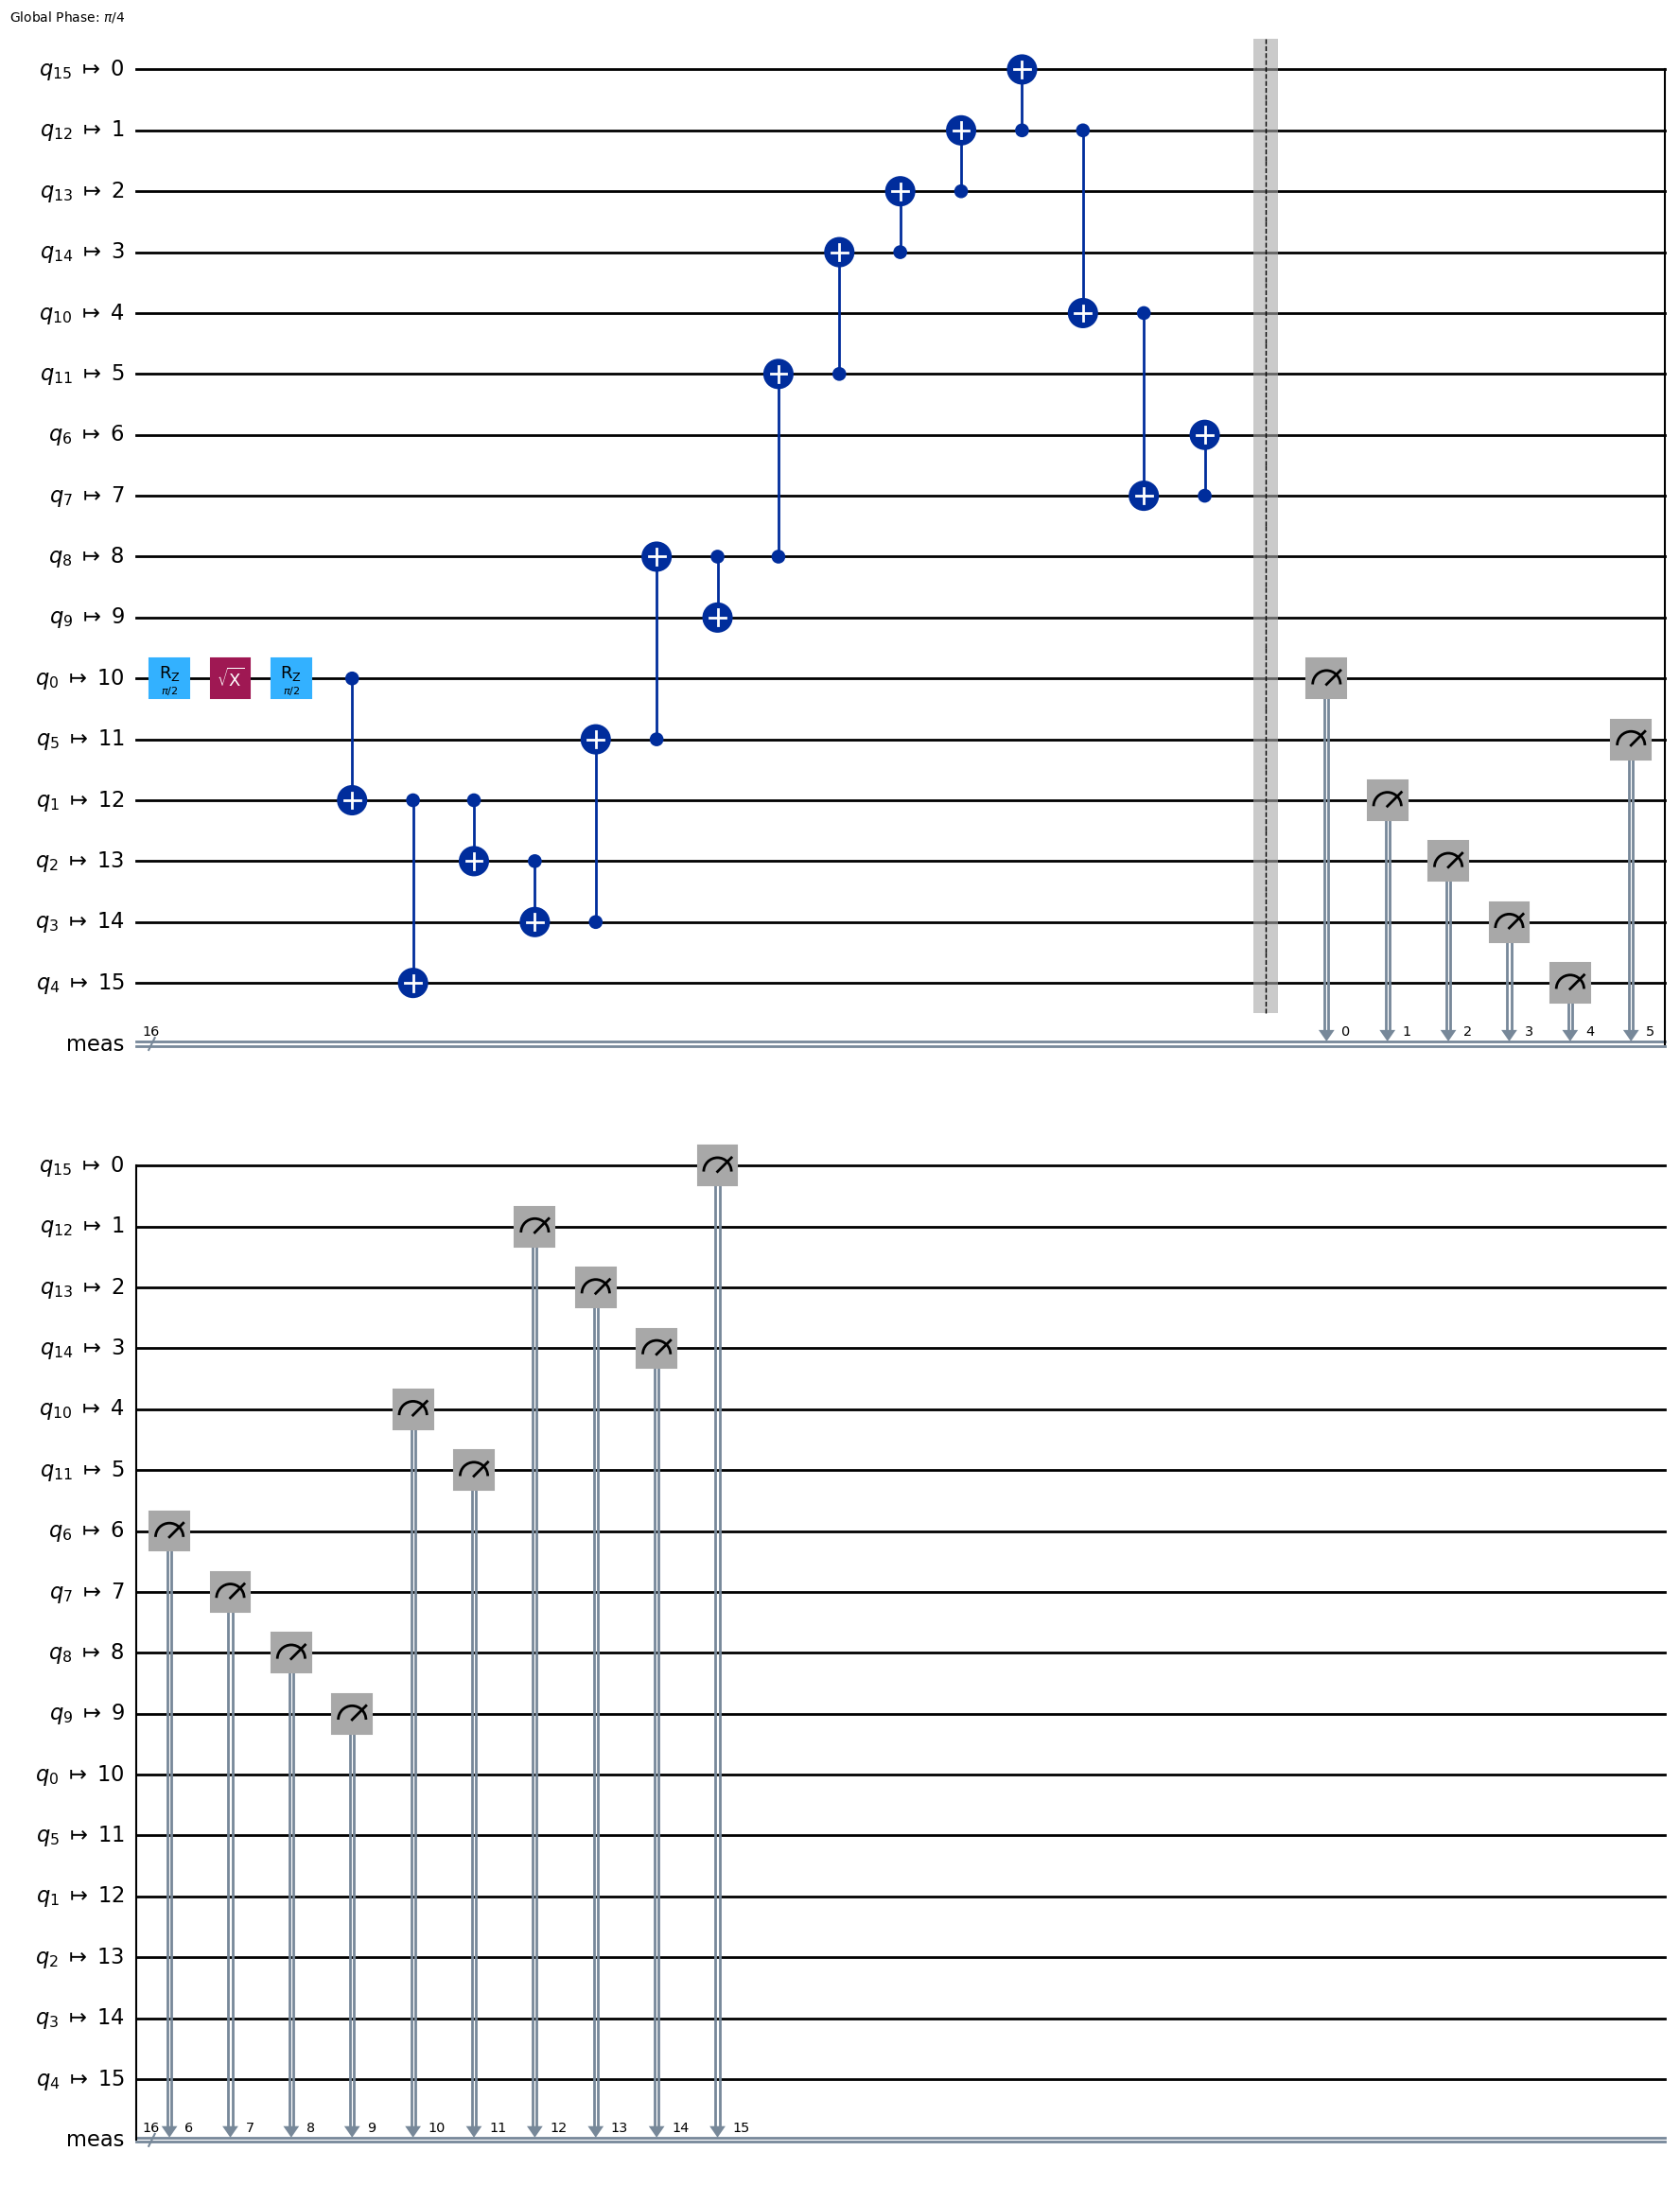

In [8]:
transpiled_qc.draw('mpl')

In [9]:
results = sampler_fake_backend_guadalupe.run([transpiled_qc])

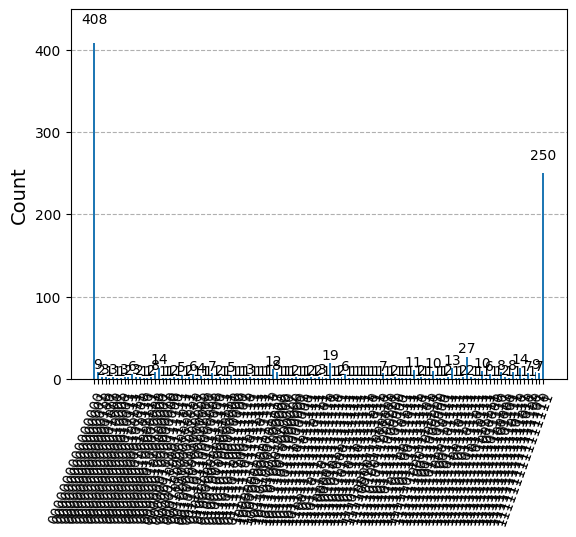

In [10]:
counts = results.result()[0].data.meas.get_counts()
fig = plot_histogram(counts)
fig.savefig(f"{FILE_PREFIX}-counts.png")
display(fig)

---

In [11]:
cuts = cut_circuit_wires(
    circuit=qc,
    method="manual",
    subcircuit_vertices=[list(range(5)), list(range(5,10)), list(range(10, 15))]
)
save_cuts(cuts, FILE_PREFIX)


--------------------
num_cuts = 2
subcircuit 0
ρ qubits = 0, O qubits = 1, width = 6, effective = 5, depth = 6, size = 6
     ┌───┐                         
q_0: ┤ H ├──■──────────────────────
     └───┘┌─┴─┐                    
q_1: ─────┤ X ├──■────■────────────
          └───┘  │  ┌─┴─┐          
q_2: ────────────┼──┤ X ├──■───────
                 │  └───┘┌─┴─┐     
q_3: ────────────┼───────┤ X ├──■──
               ┌─┴─┐     └───┘  │  
q_4: ──────────┤ X ├────────────┼──
               └───┘          ┌─┴─┐
q_5: ─────────────────────────┤ X ├
                              └───┘
subcircuit 1
ρ qubits = 1, O qubits = 1, width = 6, effective = 5, depth = 5, size = 5
                              
q_0: ──■──────────────────────
     ┌─┴─┐                    
q_1: ┤ X ├──■────■────────────
     └───┘┌─┴─┐  │            
q_2: ─────┤ X ├──┼────────────
          └───┘┌─┴─┐          
q_3: ──────────┤ X ├──■───────
               └───┘  │  ┌───┐
q_4: ─────────────────┼──┤ X ├
              

--------------------
Saving cuts as JSON...


In [12]:
subcircuit_instance_probabilities = evaluate_subcircuits(cuts)
save_probs(subcircuit_instance_probabilities,FILE_PREFIX)

Saving probabilities as JSON...


In [13]:
reconstructed_probabilities = reconstruct_full_distribution(
    qc, subcircuit_instance_probabilities, cuts
)
save_reconstructed_probs(reconstructed_probabilities, FILE_PREFIX)

Saving reconstructed probabilities as JSON...


In [14]:
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=n_qubits)

In [18]:
# cut zeros
final_dist = {}
for k,v in reconstructed_dict_bitstring.items():
    if(v != 0):
        final_dist[k] = v
final_dist

{'0000000000000000': 0.4999999999999999,
 '1111111111111111': 0.4999999999999999}

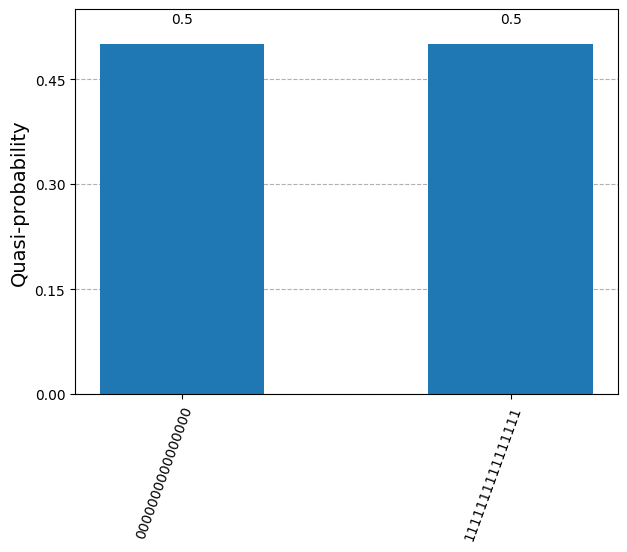

In [19]:
fig = plot_distribution(final_dist)
fig.savefig(f"{FILE_PREFIX}-circuit-cutting.png")
display(fig)